m

### IPC
1. processes share memeory: data in shared memory
1. processes exchange messages: message passing via sockets
1. Requires synchronization: mutexes, waiting


1. refered to a set of mechanisms that OS supports in order to perform multi processes to interact among each other (coordicnation & communication)


Two catagories:
1. message passing: sockets, pipes, message queues
1. memory-based IPC: shared memory, memory mapped files
1. higher-level semantics: files, RPC (Remote Procedure Call) 
1. Synchronization primitives 




### Message-passing

send/recv of messages
1. OS creates and maintains a channel: buffer, FIFO queue
1. OS provides interface to processes: a port
1. processes send/write messages to a port
1. processes recv/read messages from a port


Kernel required to 
1. establish communication
1. perform each IPC operation
1. send: system call + data copy
1. recv: system call + data copy


Request-response:
1. 4x user/kernel crossings
1. 4 data copies

Pros:
1. Simplicity: kernel does channel management and synchronization
Cons:
1. Overhead
 


#### Pipes: charactered by two end points
1. carry byte stream between 2 processes
1. push a stream of bytes from one process to the other 
1. connect output from one process to input of another 


#### Message Queues
1. carry messages among processes 
1. OS management includes priorities, scheduling of meessage delivery
1. APIs: SysV and POSIX

#### Scokets: ports are the sockets abstraction by the OS
1. send(), recv() == pass message buffers
1. sockets() == create kernel-level socket buffer
1. associate nessary kernel-level processing necessary for the message movement (TCP/IP ...)
    1. if different machines, channel between process and network device 
    1. if same machine, bypass full protocol stack


#### Shared Memory IPC
1. read and write to shared memory region
1. OS establishes shared channel between teh processes
    1. physical pages mapped into virtual address space
    1. VA(P1) and VA(P2) map to the same physical address
    1. VA region (P1) doesn't have the same virtual addresses as VA(P2)
    1. the underlying physhical memory doesn't need to be contiguous
    
Pros: 
1. System calls only for setup 
1. data copies potentially reduced (but not eliminated) 
Cons:
1. need explicity synchronization
1. developers need to determine any communciation protocol related issues, how the shared buffer should be allocated (management) 

APIs:
1. SysV
1. POSIX
1. memory mapped fiels
1. Android ashmem



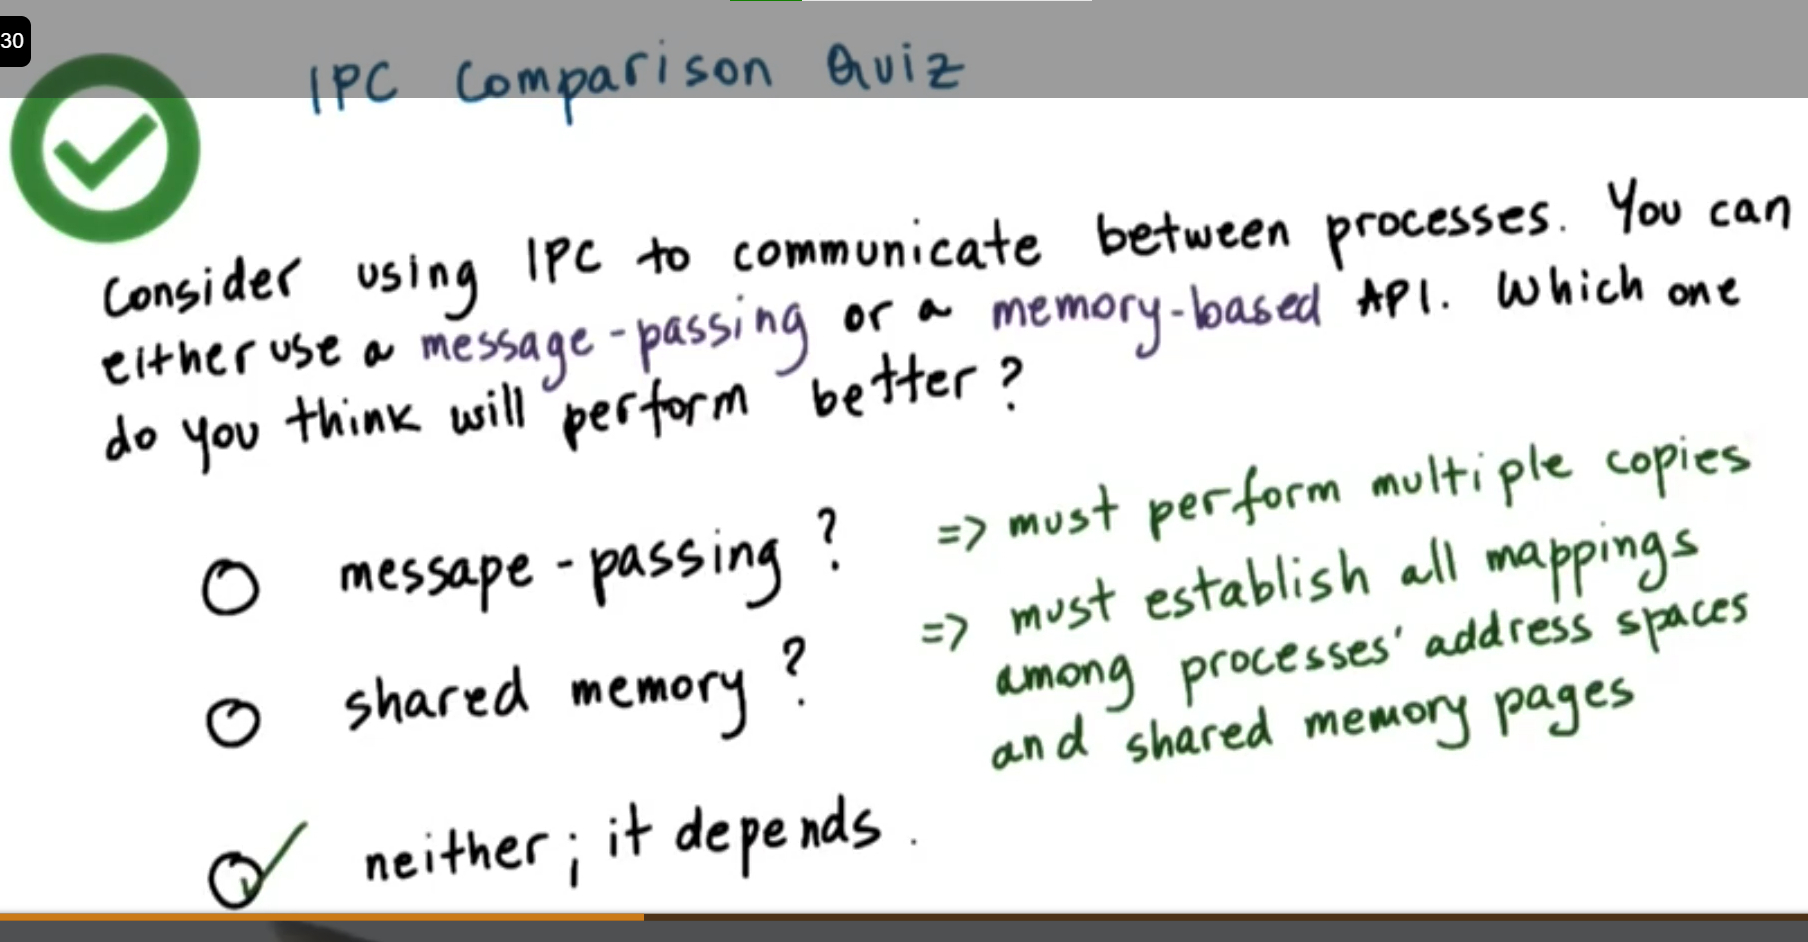

### Copy (messages) vs Shared Memory
Goal: transfer data from one address space into target address space


Copy:
1. CPU cycles to copy data to/from port

Map:
1. CPU cycles to map memory into address space
1. CPU to copy data to chanenel (no user/kernel level switch required) 
1. Set up the channel is a costly operation
1. Set up once use many times, then it will result in good payoff
1. Can perform well for 1-time use: large amount of data, when t(copy)>>t(map)

Windows system internally exercises tradeoff in "local" procedure calls (LPC). 
1. if data transfered is smaller than a threadhold, then it will be copied
1. otherwise map the address space to the target process


### SysV Shared Memory Overview
1. Segment of shared memory: not necessarily contiguous physical pages
1. OS treats shared memory as system-wide resources: system limits on number of segments and total size (currently linux's limit is 4000 segments)
1. Create: When a process requests, a shared memory is created, the OS allocates the required amount of memory and then assigns a unique key. The key is used to identify the segment in the OS. 
1. Attach: Using the key the shared memory segment can be attached by processes 
    1. OS establishes valid mapping between virtual addresses in a process and the actual physical addresses of that segment
1. Detach: detach a segment means invalidate the address mappings for the segment in the process. 
1. Destroy: a segment can be attached and detached multi times by different processes. Destoried only when explicitly requested (or reboot). Not destories when processes exit.

### SysV Shared memory API
1. shmget(shmid, size, flag): to create or open a segment of the size
    1. https://man7.org/linux/man-pages/man2/shmget.2.html
    1. flag includes various options including permissions 
    1. shmid: a unique identifier is the key passed to the OS by the application, created by ftok
1. ftok(pathname, prg_id):
    1. https://man7.org/linux/man-pages/man3/ftok.3.html
    1. generate a token by its arguments
    1. same args=>same key
1. shmat(shmid, addr, flags): attach shared memory to the process's virtual address space
    1. https://man7.org/linux/man-pages/man3/shmat.3p.html
    1. addr = NULL -> arbitrary: the program can provide the virtual addresses the segment can be mapped or the system will return a suitable address if it's NULL
    1. cast address to arbitrary type: return of memeory need to be casted to an appropriate type
1. shmdt(shmid): detach a segment, the mapping is no longer valid
    1. https://linux.die.net/man/2/shmdt
1. shmctl(shmid, cmd, buf), pass command related to shared memory 
    1. https://man7.org/linux/man-pages/man2/shmctl.2.html
    1. destroy with IPC/RMID (command to remove a particular segment):     msgctl(msgid, IPC_RMID, NULL);


### POSIX Shared Memory API
Instead of segment POSIX uses file, keys == file descriptor

1. shm_open()
    1. returns file descriptor
    1. in tmpfs (temp file system, looks like a file system but only in memory)
1. mmap()/unmmap()
    1. mapping virtual to physical addresses
1. shm_close()
    1. remove the shared memory from the process
1. shm_unlink()
    1. destory the shared memory
    

### Shared Memory and Synchronization

Synchronization methods
1. mechanisms suported by process threading library (pthreads)
1. OS-supported IPC for synchronization

Both methods must coordinate
1. number of concurrent accesses to shared segment
1. when data is avaiable and ready for consumption



### Pthreads sync for IPC

Add PTHREAD_PROCESS_SHARED to
1. pthread_mutexattr_t
1. pthread_condattr_t
Synchronization data structures must be shared among processes.

In [ ]:
//... make shm data struct
typedef struct {
    pthread_mutex_t mutex; //mutex for the data below
    char *data; // actual data
} shm_data_struct, *shm_data_struct_t;

// ... create shm segment
seg = shmget(ftok(arg[0], 120), 1024, IPC_CREATE|IPC_EXCL)); //get segment identifier
shm_address = shmat(seg, (void *) 0, 0);//attech the segment and get virtual memory address in the process for shared memory address
shm_ptr = (shm_data_struct_t_) shm_address; // parse the address to a particular data structure


// ...create and init mutex
pthread_mutexattr_t(&m_attr);
pthread_mutexattr_set_pshared(&m_attr, PTHREAD_PROCESS_SHARED);
pthread_mutex_init(&shm_prt.mutex, &m_attr)

### Other IPC Sync


1. Message Queues
    1. implement mutual exclusion via send/recv
    1. example protocol:
        1. P1 wriet data to shmem, sends "ready" to queue
        1. P2 receives message, reads data & sends "ok" message back
1. Semaphores
    1. binary semaphores: have two values 0/1
        1. if 0: stop/block
        1. if 1: decrement (set to 0 to lock) and go/proceed
    

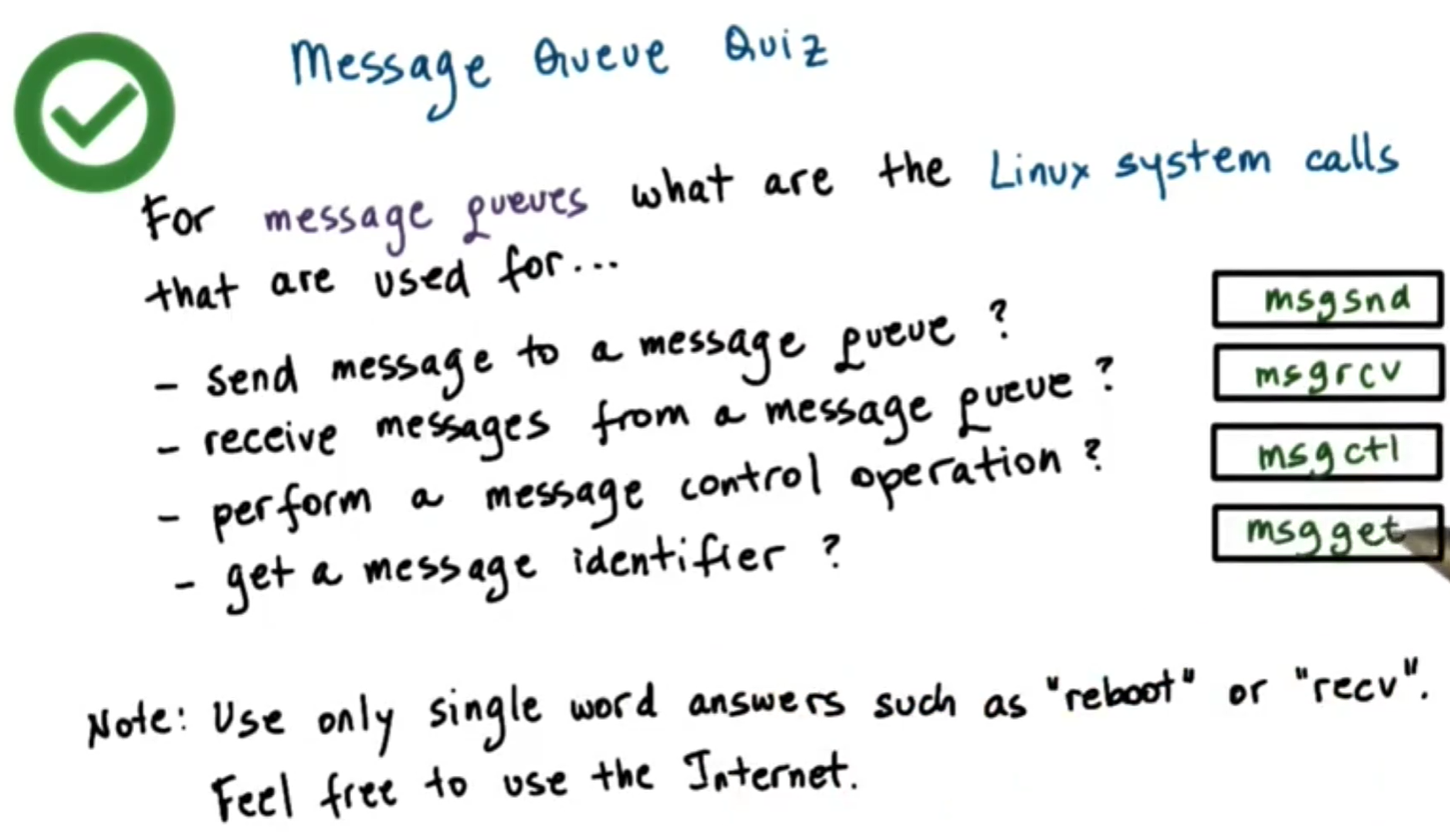

### IPC Command Line tools
1. ipcs
    1. list all IPC facilities
    1. -m: displays info on shared memory IPC only
1. ipcrm
    1. delete IPC facility
    1. -m [shmid]: deletes shm segment with given id

### Shared Memory Design Considerations
1. different APIs/mechanisms for synchronization 
1. OS provides shared memory and is out of the way
1. data passing/synchronization protocols are up to the programmer


#### How many segments?
1. one large segment
    1. manager for allocating/freeing memory ffrom shared segment
1. many small segments
    1. use pool of segments, queue of segment ids
    1. communicate segment IDs among processes
    
    
#### What size segments? What if data doesn't fit?
1. if size is static and well-known: segment size = data size
1. otherwise: limit max data size can be transfered between processes. OS also has limitation on segment size.
1. if message size >> segment size: transfer data in round, include protocol to track progress
